### IMDB Dataset [URL](http://ai.stanford.edu/~amaas/data/sentiment/) for Sentiment analysis for movies reviews 

### Word embedding projection [URL](http://projector.tensorflow.org/)

In [1]:
import tensorflow as tf
tf.enable_eager_execution()
import numpy as np

### Install the tenser flow dataset using below pip code
pip install -q tensorflow-datasets

### Import Imdb review dataset from tensorflow library

In [2]:
import tensorflow_datasets as tf_ds

In [3]:
imdb,info=tf_ds.load("imdb_reviews",with_info=True,as_supervised=True)

### Divide the dataset into training and testing set 25k on train and 25 k on test

In [4]:
data_train,data_test=imdb['train'],imdb['test']

In [5]:
x_train=[] # Sentance of review of training data (data_train)
y_train=[] # label of review of training data (data_train)
x_test=[] # Sentance of review of testing data (data_test)
y_test=[] # label of review of testing data (data_test)

### Run the for loop and append each sentance and lables in array

In [6]:
for x,y in data_train:
    x_train.append(str(x.numpy()))
    y_train.append(str(y.numpy()))

In [7]:
for x,y in data_test:
    x_test.append(str(x.numpy()))
    y_test.append(str(y.numpy()))

### Converting all the labels(y_train,y_test) into numpy array

In [8]:
y_train_final=np.array(y_train)
y_test_final=np.array(y_test)

In [9]:
y_train_final.dtype

dtype('<U1')

In [10]:
y_train_final=y_train_final.astype('int32') 
y_test_final=y_test_final.astype('int32')

### Declearing the important variable for word imbedding 

In [11]:
vocab_size=15000
embed_dim=20
max_len=140
trunc_type='post'
oov_tok="<OOV>"
num_epochs = 150

### Tokenize the sentance into word  and Pad the data to form the same length of sequience of data

In [12]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping

In [13]:
tokenizer=Tokenizer(num_words=vocab_size,oov_token=oov_tok)
#fit_on_texts will take the data and encode it
tokenizer.fit_on_texts(x_train)
#it will provide the word index property in dectionary form
word_index=tokenizer.word_index

In [14]:
x_train_sequences=tokenizer.texts_to_sequences(x_train)
x_train_padded=pad_sequences(x_train_sequences,maxlen=max_len,truncating=trunc_type)

In [15]:
x_test_sequences=tokenizer.texts_to_sequences(x_test)
x_test_padded=pad_sequences(x_test_sequences,maxlen=max_len)

### Building a keras model

In [16]:
model=tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size,embed_dim,input_length=max_len),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(6,activation="tanh"),
    tf.keras.layers.Dense(1,activation="sigmoid")    
])

### How can we use the vector

In [17]:
optimizer = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, decay=0.001)
model.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 140, 20)           300000    
_________________________________________________________________
flatten (Flatten)            (None, 2800)              0         
_________________________________________________________________
dense (Dense)                (None, 6)                 16806     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 7         
Total params: 316,813
Trainable params: 316,813
Non-trainable params: 0
_________________________________________________________________


In [18]:
earlyStopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, min_delta=0.01) 

modelCheckpoint = ModelCheckpoint('word_embedding.hdf5', monitor='val_acc', verbose=1, save_best_only=True, mode='max')

In [19]:
history=model.fit(x_train_padded, y_train_final,batch_size = 32,callbacks=[earlyStopping,modelCheckpoint], epochs=num_epochs, validation_data=(x_test_padded, y_test_final))

Train on 25000 samples, validate on 25000 samples
Epoch 1/150
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


24992/25000 [============================>.] - ETA: 0s - loss: 0.6897 - acc: 0.5377
Epoch 00001: val_acc improved from -inf to 0.58056, saving model to word_embedding.hdf5
25000/25000 [==============================] - 6s 241us/sample - loss: 0.6897 - acc: 0.5378 - val_loss: 0.6858 - val_acc: 0.5806
Epoch 2/150
24960/25000 [============================>.] - ETA: 0s - loss: 0.6696 - acc: 0.6630
Epoch 00002: val_acc improved from 0.58056 to 0.66516, saving model to word_embedding.hdf5
25000/25000 [==============================] - 5s 209us/sample - loss: 0.6696 - acc: 0.6631 - val_loss: 0.6621 - val_acc: 0.6652
Epoch 3/150
24704/25000 [============================>.] - ETA: 0s - loss: 0.6330 - acc: 0.7198
Epoch 00003: val_acc improved from 0.66516 to 0.71828, saving model to word_embedding.hdf5
25000/25000 [==============================] - 5s 191us/sample - loss: 0.6327 - acc: 0.7204 - val_loss: 0.6222 - val_acc: 0.7183
Epoch 4/150
24768/25000 [============================>.] - ETA: 0s 

Epoch 27/150
24576/25000 [============================>.] - ETA: 0s - loss: 0.3217 - acc: 0.8829
Epoch 00027: val_acc improved from 0.84888 to 0.84904, saving model to word_embedding.hdf5
25000/25000 [==============================] - 7s 276us/sample - loss: 0.3220 - acc: 0.8830 - val_loss: 0.3671 - val_acc: 0.8490
Epoch 28/150
24704/25000 [============================>.] - ETA: 0s - loss: 0.3192 - acc: 0.8835
Epoch 00028: val_acc improved from 0.84904 to 0.85020, saving model to word_embedding.hdf5
25000/25000 [==============================] - 5s 191us/sample - loss: 0.3192 - acc: 0.8835 - val_loss: 0.3651 - val_acc: 0.8502
Epoch 29/150
24832/25000 [============================>.] - ETA: 0s - loss: 0.3162 - acc: 0.8847
Epoch 00029: val_acc improved from 0.85020 to 0.85080, saving model to word_embedding.hdf5
25000/25000 [==============================] - 5s 195us/sample - loss: 0.3165 - acc: 0.8843 - val_loss: 0.3634 - val_acc: 0.8508
Epoch 30/150
24832/25000 [=======================

In [20]:
#history=model.fit(x_train_padded, y_train_final,epochs=num_epochs, validation_data=(x_test_padded, y_test_final))

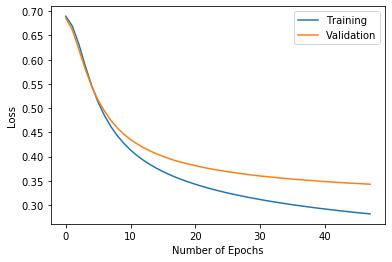

In [31]:
import matplotlib.pyplot as plt 
plt.plot(history.history['loss'], label='Training') 
plt.plot(history.history['val_loss'], label='Validation') 
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

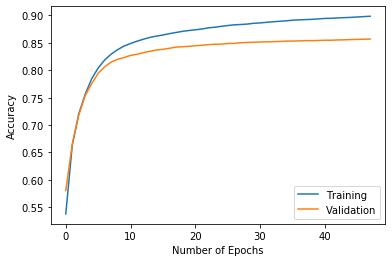

In [32]:
plt.plot(history.history['acc'], label='Training') 
plt.plot(history.history['val_acc'], label='Validation') 
plt.xlabel("Number of Epochs")
plt.ylabel("Accuracy")
plt.legend("Accuracy garph")
plt.legend()
plt.show()

In [22]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)

(15000, 20)


In [23]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

print(decode_review(x_train_padded[1]))
print(x_train[1])

b perhaps because i was so young innocent and brainwashed when i saw it this movie was the cause of many sleepless nights for me i haven't seen it since i was in seventh grade at a <OOV> school so i am not sure what effect it would have on me now however i will say that it left an impression on me and most of my friends it did serve its purpose at least until we were old enough and knowledgeable enough to analyze and create our own opinions i was particularly terrified of what the newly converted post rapture christians had to endure when not receiving the mark of the beast i don't want to spoil the movie for those who haven't seen it so i will not mention details of the scenes but i can still picture
b"Perhaps because I was so young, innocent and BRAINWASHED when I saw it, this movie was the cause of many sleepless nights for me. I haven't seen it since I was in seventh grade at a Presbyterian school, so I am not sure what effect it would have on me now. However, I will say that it le

### here we are just revesing the order of word and number (word:number to number:word)

In [24]:
import io

out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for word_num in range(1, vocab_size):
  word = reverse_word_index[word_num]
  embeddings = weights[word_num]
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()

In [25]:
sentence = "I think this is good."
sequence = tokenizer.texts_to_sequences(sentence)
print(sequence)

[[11], [], [790], [2012], [11], [2920], [2188], [], [790], [2012], [11], [579], [], [11], [579], [], [1277], [1003], [1003], [960], []]
